In [8]:
!pip install pyspark
!pip install matplotlib

In [9]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, PCA
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.linalg import Vectors
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

**a) Câu 1 (2.0 điểm): Phân cụm dữ liệu**

In [10]:
class KMeansAnalysis:
    def __init__(self, spark):
        self.spark = spark

    def read_data(self, file_path):
        # Đọc dữ liệu từ file CSV và trả về DataFrame
        df = self.spark.read.csv(file_path, header=False, inferSchema=True)
        return df

    def preprocess_data(self, df):
        # Loại bỏ cột đầu tiên (loại ký số)
        df = df.drop("_c0")

        # Tạo vector từ các cột pixel
        assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
        df = assembler.transform(df)

        # Định nghĩa UDF để nhân trọng số
        multiply_weights_udf = F.udf(lambda features, weights: [feature * weight for feature, weight in zip(features, weights)], ArrayType(DoubleType()))

        # Gán trọng số gấp 100 lần cho các điểm dữ liệu được chỉ định
        weights = [100 if i in [0, 1, 2, 3, 4, 7, 8, 11, 18, 61] else 1 for i in range(df.count())]
        df = df.withColumn("weight", F.array([F.lit(w) for w in weights]))

        # Nhân trọng số vào các thành phần của vector bằng UDF
        df = df.withColumn("weighted_features", multiply_weights_udf("features", "weight"))

        return df

    def run_kmeans(self, df, k):
        # Khởi tạo và chạy thuật toán KMeans với số cụm k
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(df)
        return model

    def calculate_avg_distance(self, model):
        # Lấy ra centroids từ model
        centroids = model.clusterCenters()

        # Sử dụng hàm transform để dự đoán nhóm cho mỗi điểm dữ liệu và tính khoảng cách tới centroid
        df_with_prediction = model.transform(df)

        # Tính khoảng cách từ mỗi điểm tới centroid của nhóm mà nó thuộc với
        distances = df_with_prediction.select("prediction", "features") \
                                      .rdd.map(lambda row: (row.prediction, (Vectors.squared_distance(row.features, centroids[row.prediction]), 1))) \
                                      .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
                                      .collect()

        # Tính trung bình khoảng cách cho mỗi cụm
        avg_distances = [total_distance / count for _, (total_distance, count) in distances]

        return avg_distances

    def plot_avg_distances(self, cluster_avg_distances):
        # Trích xuất cluster và giá trị trung bình khoảng cách
        clusters = list(range(1, len(cluster_avg_distances) + 1))
        avg_distances_list = cluster_avg_distances

        # Vẽ biểu đồ cột
        plt.figure(figsize=(10, 6))
        plt.bar(clusters, avg_distances_list)
        plt.xlabel('Cluster')
        plt.ylabel('Average Distance to Centroid')
        plt.title('Average Distance to Centroid for Each Cluster')
        plt.show()

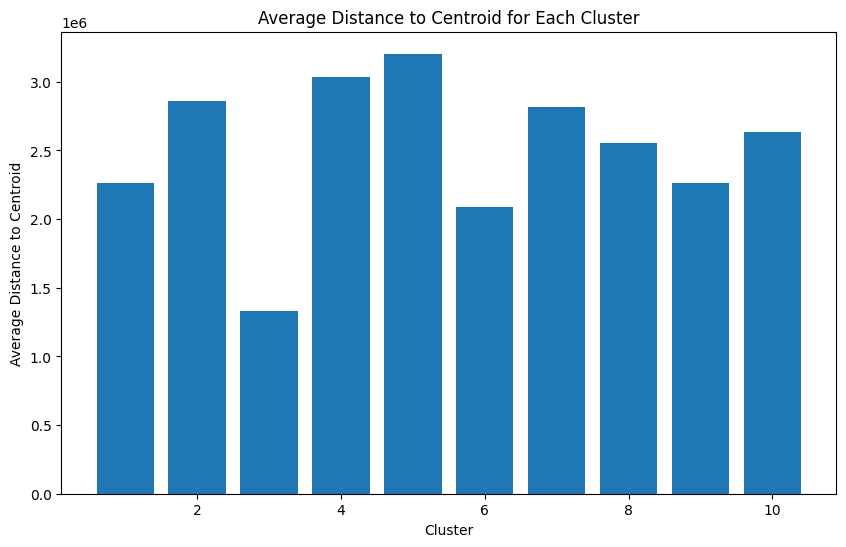

In [11]:
if __name__ == "__main__":
    # Khởi tạo SparkSession
    spark = SparkSession.builder \
        .appName("KMeansAnalysis") \
        .getOrCreate()

    # Đường dẫn tới tập dữ liệu
    file_path = "mnist_mini.csv"

    # Khởi tạo đối tượng phân tích KMeans
    kmeans_analysis = KMeansAnalysis(spark)

    # Đọc dữ liệu
    df = kmeans_analysis.read_data(file_path)

    # Tiền xử lý dữ liệu
    df = kmeans_analysis.preprocess_data(df)

    # Chạy thuật toán KMeans với k=10
    k = 10
    model = kmeans_analysis.run_kmeans(df, k)

    # Tính toán trung bình khoảng cách cho mỗi cluster
    cluster_avg_distances = kmeans_analysis.calculate_avg_distance(model)

    # Vẽ biểu đồ cột
    kmeans_analysis.plot_avg_distances(cluster_avg_distances)

    # Đóng SparkSession
    spark.stop()

**b) Câu 2 (2.0 điểm): Giảm số chiều với SVD**

In [12]:
class DimensionalityReduction:
    def __init__(self, spark):
        self.spark = spark

    def read_data(self, file_path):
        # Đọc dữ liệu từ file CSV và trả về DataFrame
        df = self.spark.read.csv(file_path, header=False, inferSchema=True)
        return df

    def preprocess_data(self, df):
        # Lưu lại cột đầu tiên (label)
        labels = df.select("_c0").withColumnRenamed("_c0", "label")

        # Tạo vector từ các cột pixel (bỏ cột đầu tiên)
        assembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")
        df = assembler.transform(df.drop("_c0"))

        # Thêm lại cột label vào DataFrame với id duy nhất
        df = df.withColumn("id", monotonically_increasing_id())
        labels = labels.withColumn("id", monotonically_increasing_id())
        df = df.join(labels, "id", "inner")

        return df

    def reduce_dimensions(self, df, k):
        # Chuyển đổi DataFrame thành RDD
        rdd = df.select("features").rdd.map(lambda row: DenseVector(row[0]))

        # Tạo RowMatrix từ RDD
        mat = RowMatrix(rdd)

        # Thực hiện SVD
        svd = mat.computeSVD(k, computeU=True)
        U = svd.U.rows.map(lambda row: row.toArray().tolist()).collect()
        s = svd.s
        V = svd.V

        # Tạo DataFrame từ kết quả SVD
        svd_features = [Vectors.dense(row) for row in U]
        ids = df.select("id").rdd.map(lambda row: row[0]).collect()
        svd_df = self.spark.createDataFrame([(int(id), svd_features[i]) for i, id in enumerate(ids)], ["id", "svd_features"])
        svd_df = svd_df.join(df.select("id", "label"), "id", "inner")
        return svd_df

    def sample_data(self, df, sample_size):
        # Chọn ngẫu nhiên sample_size điểm dữ liệu
        sampled_df = df.sample(False, sample_size / df.count()).limit(sample_size)
        return sampled_df

    def run_kmeans_on_reduced_data(self, df, k):
        # Chạy thuật toán KMeans trên dữ liệu đã giảm số chiều
        kmeans = KMeans(featuresCol="svd_features", k=k)
        model = kmeans.fit(df)
        return model

    def get_cluster_labels(self, model, df):
        # Lấy nhãn phân cụm từ model KMeans
        predictions = model.transform(df)
        cluster_labels = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()
        return cluster_labels

    def plot_3d_clusters(self, sampled_df, cluster_labels):
        # Chuyển đổi dữ liệu thành danh sách để vẽ biểu đồ
        sampled_features = [row['svd_features'] for row in sampled_df.collect()]
        features_3d = [list(x) for x in sampled_features]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Vẽ các điểm dữ liệu với màu sắc dựa trên nhãn phân cụm
        scatter = ax.scatter(
            [x[0] for x in features_3d],
            [x[1] for x in features_3d],
            [x[2] for x in features_3d],
            c=cluster_labels, cmap='viridis'
        )

        # Thêm màu sắc cho legend
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)

        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        plt.title('3D Scatter Plot of Data after SVD')
        plt.show()


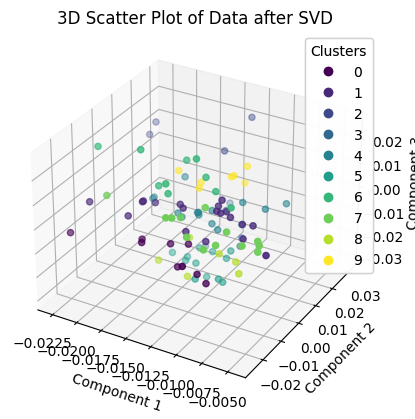

In [13]:
if __name__ == "__main__":
    # Khởi tạo SparkSession
    spark = SparkSession.builder \
        .appName("DimensionalityReduction") \
        .getOrCreate()

    # Đường dẫn tới tập dữ liệu
    file_path = "mnist_mini.csv"

    # Khởi tạo đối tượng giảm số chiều
    dr = DimensionalityReduction(spark)

    # Đọc và tiền xử lý dữ liệu
    df = dr.read_data(file_path)
    df = dr.preprocess_data(df)

    # Giảm số chiều xuống 3 bằng SVD
    k_SVD = 3
    reduced_df = dr.reduce_dimensions(df, k_SVD)

    # Chạy thuật toán KMeans trên dữ liệu đã giảm số chiều với k=10
    k_KMeans = 10
    model = dr.run_kmeans_on_reduced_data(reduced_df, k_KMeans)

    # Chọn ngẫu nhiên 100 điểm dữ liệu sau khi giảm số chiều
    sample_size = 100
    sampled_df = dr.sample_data(reduced_df, sample_size)

    # Lấy nhãn phân cụm từ model KMeans
    cluster_labels = dr.get_cluster_labels(model, sampled_df)

    # Vẽ biểu đồ 3D
    dr.plot_3d_clusters(sampled_df, cluster_labels)

    # Đóng SparkSession
    spark.stop()


**c) Câu 3 (2.0 điểm): Khuyến nghị sản phẩm với Collaborative Filtering**

root
 |-- index: integer (nullable = true)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- rating: double (nullable = true)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0|
|    6|  72| 426|   4.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|    9|  59|  22|   3.5|
|   10|   8| 174|   2.0|
|   11|   5| 149|   2.0|
|   12|  26| 322|   3.5|
|   13|   8| 416|   4.0|
|   14|  31|  25|   2.0|
|   15|  41|  83|   2.0|
|   16|  25| 321|   3.0|
|   17|  47| 193|   3.0|
|   18|   9| 455|   4.0|
|   19|  43| 216|   3.5|
+-----+----+----+------+
only showing top 20 rows

Dữ liệu Huấn luyện:
+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0

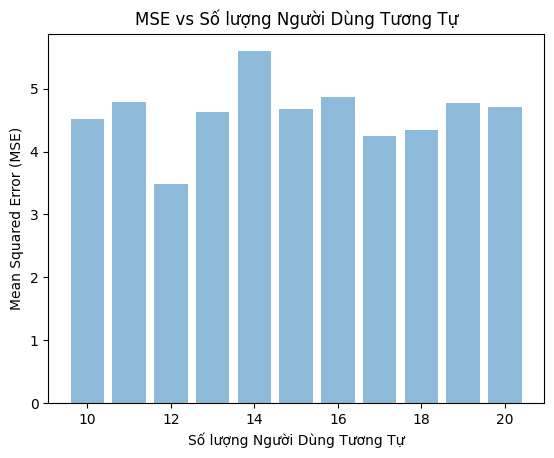

In [14]:
class CollaborativeFilteringModel:
    def __init__(self, spark, file_path):
        # Khởi tạo phiên Spark và đường dẫn tệp
        self.spark = spark
        self.file_path = file_path
        # Khởi tạo dữ liệu, tập huấn luyện và tập kiểm tra
        self.data = None
        self.train = None
        self.test = None
        # Khởi tạo danh sách để lưu trữ các giá trị MSE
        self.mse_values = []

    def load_data(self):
        # Tải dữ liệu từ tệp CSV vào DataFrame
        self.data = self.spark.read.csv(self.file_path, header=True, inferSchema=True)
        # In schema và hiển thị dữ liệu
        self.data.printSchema()
        self.data.show()

    def split_data(self):
        # Phân chia dữ liệu thành các tập huấn luyện và kiểm tra
        self.train, self.test = self.data.randomSplit([0.7, 0.3], seed=123)
        # In dữ liệu huấn luyện và kiểm tra
        print("Dữ liệu Huấn luyện:")
        self.train.show()
        print("Dữ liệu Kiểm tra:")
        self.test.show()

    def run_inference(self, num_similar_users):
        # Lặp qua các số lượng người dùng tương tự khác nhau
        for num_users in num_similar_users:
            # Cấu hình mô hình ALS
            als = ALS(maxIter=5, regParam=0.01, userCol="user", itemCol="item", ratingCol="rating",
                      coldStartStrategy="drop", numUserBlocks=num_users, numItemBlocks=num_users)
            # Huấn luyện mô hình ALS với dữ liệu huấn luyện
            model = als.fit(self.train)
            # Dự đoán trên dữ liệu kiểm tra
            predictions = model.transform(self.test)
            # Đánh giá mô hình sử dụng MSE
            evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
            mse = evaluator.evaluate(predictions)
            # Thêm giá trị MSE vào danh sách
            self.mse_values.append(mse)
            # In MSE cho số lượng người dùng tương tự hiện tại
            print(f"Mean Squared Error (MSE) với {num_users} người dùng tương đồng =", mse)

    def plot_mse(self, num_similar_users):
        # Vẽ biểu đồ MSE so với số lượng người dùng tương tự
        plt.bar(num_similar_users, self.mse_values, align='center', alpha=0.5)
        plt.xlabel('Số lượng Người Dùng Tương Tự')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.title('MSE vs Số lượng Người Dùng Tương Tự')
        plt.show()

if __name__ == "__main__":
    # Khởi tạo SparkSession
    spark = SparkSession.builder \
        .appName("Collaborative Filtering Recommendation") \
        .getOrCreate()

    file_path = "ratings2k.csv"

    # Khởi tạo mô hình collaborative filtering
    cf_model = CollaborativeFilteringModel(spark, file_path)
    cf_model.load_data()
    cf_model.split_data()

    # List chứa các giá trị số lượng người dùng tương đồng cần khảo sát
    num_similar_users = range(10, 21)

    # Chạy inference để đánh giá hiệu suất của mô hình và tính toán MSE
    cf_model.run_inference(num_similar_users)

    # Vẽ biểu đồ MSE
    cf_model.plot_mse(num_similar_users)

    # Đóng SparkSession
    spark.stop()

**d) Câu 4 (2.0 điểm): Dự đoán giá chứng khoán.**

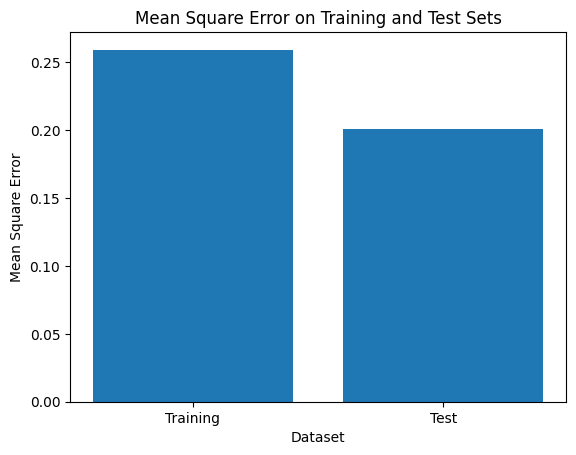

Mean Square Error on Training Set: 0.2592328026061045
Mean Square Error on Test Set: 0.20097152661117487


In [15]:
class StockPredictor:
    def __init__(self, spark, file_path):
        self.spark = spark
        self.file_path = file_path

    def read_data(self):
        # Đọc dữ liệu từ file CSV
        self.df = self.spark.read.csv(self.file_path, header=True, inferSchema=True)

    def calculate_fluctuation(self):
        # Tính toán biên độ dao động của giá cổ phiếu
        self.df = self.df.withColumn("fluctuation", (self.df["HVN"] - lag(self.df["HVN"], 1).over(Window.orderBy("Ngay"))) / lag(self.df["HVN"], 1).over(Window.orderBy("Ngay")))
        self.df = self.df.na.fill({"fluctuation": 0.0})

        # Tính toán biên độ dao động của giá cổ phiếu 5 ngày trước
        self.df = self.df.withColumn("fluctuation_5_days_ago", lag(self.df["fluctuation"], 5).over(Window.orderBy("Ngay")))
        self.df = self.df.na.drop()  # Loại bỏ các hàng có giá trị null (do không có dữ liệu 5 ngày trước)

        # Chọn các cột cần thiết và loại bỏ các cột không cần thiết
        self.df = self.df.select("Ngay", "fluctuation_5_days_ago", "fluctuation")

    def split_data(self):
        # Tạo DataFrame cho tập huấn luyện và tập kiểm tra
        self.train_df = self.df.filter(self.df["Ngay"] < "2022-07-01")
        self.test_df = self.df.filter(self.df["Ngay"] >= "2022-07-01")

    def prepare_features(self):
        # Tạo vector features từ cột biên độ 5 ngày trước
        assembler = VectorAssembler(inputCols=["fluctuation_5_days_ago"], outputCol="features")
        self.train_assembled = assembler.transform(self.train_df)
        self.test_assembled = assembler.transform(self.test_df)

    def train_model(self):
        # Xây dựng mô hình Linear Regression
        lr = LinearRegression(featuresCol="features", labelCol="fluctuation")
        self.lr_model = lr.fit(self.train_assembled)

    def evaluate_model(self):
        # Đánh giá mô hình trên tập huấn luyện và tập kiểm tra
        evaluator = RegressionEvaluator(labelCol="fluctuation", predictionCol="prediction", metricName="mse")
        self.train_predictions = self.lr_model.transform(self.train_assembled)
        self.test_predictions = self.lr_model.transform(self.test_assembled)
        self.train_mse = evaluator.evaluate(self.train_predictions)
        self.test_mse = evaluator.evaluate(self.test_predictions)

    def plot_mse(self):
        # Vẽ biểu đồ cột Mean Square Error trên tập huấn luyện và tập kiểm tra
        mse_values = [self.train_mse, self.test_mse]
        mse_labels = ["Training", "Test"]
        plt.bar(mse_labels, mse_values)
        plt.title("Mean Square Error on Training and Test Sets")
        plt.xlabel("Dataset")
        plt.ylabel("Mean Square Error")
        plt.show()

def main():
    # Khởi tạo SparkSession
    spark = SparkSession.builder \
        .appName("Stock Prediction") \
        .getOrCreate()

    # Đường dẫn tới file dữ liệu
    file_path = "stockHVN2022.csv"

    # Khởi tạo đối tượng StockPredictor
    stock_predictor = StockPredictor(spark, file_path)

    # Thực hiện các bước để dự đoán giá chứng khoán và vẽ biểu đồ MSE
    stock_predictor.read_data()
    stock_predictor.calculate_fluctuation()
    stock_predictor.split_data()
    stock_predictor.prepare_features()
    stock_predictor.train_model()
    stock_predictor.evaluate_model()
    stock_predictor.plot_mse()

    # In ra kết quả MSE trên tập huấn luyện và tập kiểm tra
    print("Mean Square Error on Training Set:", stock_predictor.train_mse)
    print("Mean Square Error on Test Set:", stock_predictor.test_mse)

    # Đóng SparkSession
    spark.stop()

if __name__ == "__main__":
    main()


**e) Câu 5 (1.0 điểm): Phân loại đa lớp với pyspark**

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    2    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


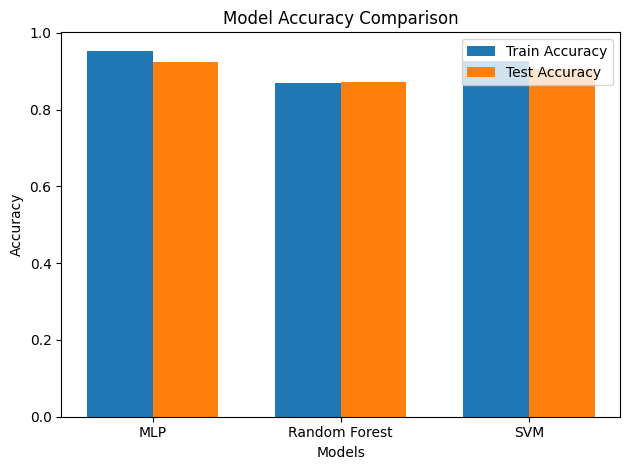

In [16]:
# Kiểm tra xem có SparkSession nào đang chạy hay không
spark = SparkSession.builder.appName("MNIST_Classification").getOrCreate()

# Lớp xử lý dữ liệu
class DataProcessor:
    def __init__(self, dataframe):
        # Chuyển đổi tên cột và tạo DataFrame Spark
        columns = ["label"] + [f"pixel_{i}" for i in range(784)]
        dataframe.columns = columns
        self.spark_df = spark.createDataFrame(dataframe)

    def preprocess(self):
        # Tạo vectơ đặc trưng và chia dữ liệu thành tập huấn luyện và tập kiểm tra
        assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(784)], outputCol="features")
        data = assembler.transform(self.spark_df).select("label", "features")
        train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)
        return train_data, test_data

# Lớp huấn luyện và đánh giá mô hình
class MNISTClassifier:
    def __init__(self):
        # Khởi tạo đối tượng MulticlassClassificationEvaluator
        self.evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

    def train_evaluate(self, model, train_data, test_data):
        # Huấn luyện mô hình và đánh giá độ chính xác
        model = model.fit(train_data)
        train_predictions = model.transform(train_data)
        test_predictions = model.transform(test_data)
        train_accuracy = self.evaluator.evaluate(train_predictions)
        test_accuracy = self.evaluator.evaluate(test_predictions)
        return train_accuracy, test_accuracy

# Lớp vẽ biểu đồ
class Plotter:
    @staticmethod
    def plot_accuracies(models, train_accuracies, test_accuracies):
        # Vẽ biểu đồ so sánh độ chính xác
        fig, ax = plt.subplots()
        index = range(len(models))
        bar_width = 0.35

        train_bar = plt.bar(index, train_accuracies, bar_width, label="Train Accuracy")
        test_bar = plt.bar([i + bar_width for i in index], test_accuracies, bar_width, label="Test Accuracy")

        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy Comparison')
        plt.xticks([i + bar_width / 2 for i in index], models)
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    # Đọc dữ liệu từ tập tin CSV
    df = pd.read_csv("mnist_mini.csv", header=None)
    print(df.head())

    # Khởi tạo lớp xử lý dữ liệu và tiến hành tiền xử lý
    data_processor = DataProcessor(df)
    train_data, test_data = data_processor.preprocess()

    # Khởi tạo lớp huấn luyện và đánh giá mô hình
    mnist_classifier = MNISTClassifier()

    # Huấn luyện và đánh giá các mô hình
    mlp = MultilayerPerceptronClassifier(layers=[784, 128, 64, 10], blockSize=128, seed=1234, maxIter=100)
    mlp_train_accuracy, mlp_test_accuracy = mnist_classifier.train_evaluate(mlp, train_data, test_data)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=1234)
    rf_train_accuracy, rf_test_accuracy = mnist_classifier.train_evaluate(rf, train_data, test_data)

    svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=100, regParam=0.1)
    ovr = OneVsRest(classifier=svm, labelCol="label", featuresCol="features")
    svm_train_accuracy, svm_test_accuracy = mnist_classifier.train_evaluate(ovr, train_data, test_data)

    # Vẽ biểu đồ so sánh độ chính xác
    models = ["MLP", "Random Forest", "SVM"]
    train_accuracies = [mlp_train_accuracy, rf_train_accuracy, svm_train_accuracy]
    test_accuracies = [mlp_test_accuracy, rf_test_accuracy, svm_test_accuracy]

    # Khởi tạo và sử dụng lớp Plotter để vẽ biểu đồ
    plotter = Plotter()
    plotter.plot_accuracies(models, train_accuracies, test_accuracies)

if __name__ == "__main__":
    main()
